# Подсчет LTV (Lifetime value) пользователей.

## 1. Введение.

### Описание проекта.

В этом проекте мы будем решать задачу подсчета LTV (Lifetime Value) пользователей сервиса. 
LTV (Lifetime Value) – это прибыль, которую средний пользователь принесет за все время использования продукта.
Метрика LTV является одной из ключевой метрик для принятия решений в маркетинге и продукте. 
Ориентируясь на метрику LTV, можно вычислить размер прибыли, которую приносит каждый покупатель за все время взаимодействия с сервисом.
Следовательно, зная значение LTV, можно более точно сформировать маркетинговый и рекламный бюджет, указать адекватную стоимость привлечения клиента (CAC) и определить коэффициент возврата инвестиции (ROI), проанализировать повышение (или понижение) лояльности аудитории к продукту.

### Цель проекта

Определение и анализ LTV(lifetime value) пользователей сервиса по имеющимся данным.

### Задача проекта

На основании определенной цели поставим следующую задачу:
- определить LTV пользователей сервиса с использованием когортного анализа.

### Описание данных

Есть два набора данных: визиты пользователей на сервис (файл visits.csv) и данные по покупкам (файл purchases.csv). У каждого визита есть источник, а также устройство, с которого заходил пользователь.

Описание столбцов в файлах с данными.

Файл visits.csv

- device — устройство,
- end_ts — дата и время окончания визита,
- source_id — id источника визита,
- start_dt — дата старта визита,
- start_ts — дата и время старта визита,
- uid — идентификатор пользователя.

Файл purchases.csv

- buy_ts — дата и время покупки,
- uid — идентификатор пользователя,
- revenue — прибыль в y.e.


### Дополнения и ограничения:
 - Подсчет метрики LTV необходимо производить на основе прибыли (contribution margin - разница между выручкой и всеми переменными затратами, которые напрямую ассоциированы с реализованной продукцией или услугой, но без учета маркетинговых расходов), а не дохода (revenue). В нашем случае имеется только столбец с данными revenue(доход) и какой либо дополнительной информации, отражающей переменные затраты на каждого пользователя нет. Поэтому для подсчета LTV (в учебных целях) мы сделаем грубое допущение о том, что в имеющихся данных указана уже посчитанная прибыль и все переменные затраты на пользователей вычтены из этого столбца.

## 2. Техническая часть.

#### Импортирование необходимых библиотек

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Настройки, необходимые для множественного вывода данных
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### Чтение и очистка данных

In [2]:
visits_data = pd.read_csv('visits.csv', sep='\t')
visits_data.head()
visits_data.info()
purchases_data = pd.read_csv('purchases.csv', sep='\t')
purchases_data.head()
purchases_data.info()

,device,end_ts,source_id,start_dt,start_ts,uid
0,desktop,2016-11-30T11:04:17Z,2,2016-11-30,2016-11-30T10:53:49Z,3758486201
1,desktop,2016-11-10T23:16:57Z,4,2016-11-10,2016-11-10T23:08:04Z,2933941628
2,desktop,2016-10-19T18:51:56Z,1,2016-10-19,2016-10-19T18:48:16Z,1465872791
3,desktop,2017-01-12T20:51:55Z,9,2017-01-12,2017-01-12T20:50:10Z,2751875787
4,touch,2016-07-23T19:17:19Z,4,2016-07-23,2016-07-23T19:10:57Z,3492372810


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720679 entries, 0 to 720678
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   device     720679 non-null  object
 1   end_ts     720679 non-null  object
 2   source_id  720679 non-null  int64 
 3   start_dt   720679 non-null  object
 4   start_ts   720679 non-null  object
 5   uid        720679 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 33.0+ MB


,buy_ts,uid,revenue
0,23.07.2016 19:13:54,3492372810,"1,47"
1,06.11.2016 02:48:27,1564753091,"1,11"
2,31.01.2017 20:32:42,1385616391,"16,8"
3,11.01.2017 10:52:11,2636761148,11
4,25.11.2016 18:57:09,2945629974,"4,89"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75716 entries, 0 to 75715
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   buy_ts   75716 non-null  object
 1   uid      75716 non-null  int64 
 2   revenue  75716 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


Проверим, имеются ли пропущенные значения в данных.

In [3]:
visits_data.isnull().sum()
purchases_data.isnull().sum()

device       0
end_ts       0
source_id    0
start_dt     0
start_ts     0
uid          0
dtype: int64

buy_ts     0
uid        0
revenue    0
dtype: int64

Пропущенных значений в данных нет.

Проверим данные из столбца прибыль на наличие выбросов.

In [4]:
purchases_data['revenue'] = purchases_data['revenue'].apply(lambda x: x.replace(',','.'))

Maximum revenue value is: 99
Minimum revenue value is: 0


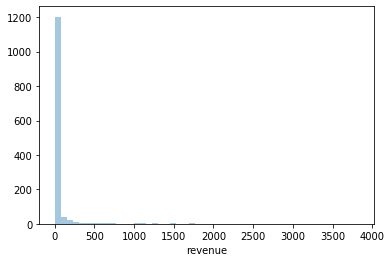

In [5]:
sns.distplot(purchases_data['revenue'].value_counts(), kde = False)
print(f"Maximum revenue value is: {purchases_data['revenue'].max()}")
print(f"Minimum revenue value is: {purchases_data['revenue'].min()}")

In [6]:
purchases_data['revenue'].describe()
purchases_data['revenue'].value_counts().sort_index()

count     75716
unique     1325
top        1.83
freq       3834
Name: revenue, dtype: object

0         57
0.01       1
0.02       1
0.03      62
0.06     211
        ... 
95.33      1
97.53      1
97.78     10
98.08      1
99         1
Name: revenue, Length: 1325, dtype: int64

На основании графика и проведенного анализа данных можно сделать вывод о том, что в данных по прибыли нет выбросов и аномальных значений. Все значения полученной прибыли от пользователей лежат в диапазоне от 0 до 99 у.е, причем большая часть платежей пользователей в сервисе составляют небольшие суммы.

### Разделение пользователей по когортам.
В качестве когорт для удобства дальнейешего анализа и визуализации выберем ежемесячные когорты (начало пользования сервисом определенным пользователем в определенный месяц). 

В когорту N-го месяца попадут пользователи, впервые начавшие пользоваться сервисом в N-ый месяц.

Таким образом на основании имеющихся у нас данных будет 12 различные когорт (с когорты 0 месяца  по когорту 12 месяца).

Аналогичным образом возможно провести анализ дневных когорт пользователей (когортой N-го дня будут пользователи, начавшие пользоваться сервисом в N-ый день и всего количество когорот увеичится с 12 до 362 (по количеству дней имеющихся для анализа)).

Проведение анализа дневных когорт имеет смысл, когда необходимо отследить изменение ключевых показателей бизнеса (LTV, конверсии, ROI, Retention Rate, САС) в условиях ограниченности времени или за малый временной промежуток, чтобы принять дальнейшее решение по развитию продукта (сервиса).

В нашем случае для отслеживания общей динамики LTV при взаимодействии пользователей с сервисом будет достаточно использовать анализ ежемесячных когорт.

#### Преобразование данных

Сделаем необходимые преобразования данных и объединим информацию о посещениях сервиса (файл visits.csv) с информацией о покупках на сервисе (файл purchases.csv).

Преобразуем данные, содержащие даты в формат datetime.

In [7]:
visits_data['start_dt'] = pd.to_datetime(visits_data['start_dt'])
purchases_data['buy_ts'] = pd.to_datetime(purchases_data['buy_ts'].apply(lambda x: x.split(' ')[0]))
purchases_data['revenue'] = purchases_data['revenue'].apply(lambda x: float(x.replace(',', '.')))

Зададим столбец дата входа в приложение(OrderPeriod) в формате Y-m для дальнейшей группировки когорт по месяцам.

In [8]:
visits_data['OrderPeriod'] = visits_data.start_dt.apply(lambda x: x.strftime('%Y-%m'))
purchases_data['buy_ts'] = purchases_data['buy_ts'].apply(lambda x: x.strftime('%Y-%m'))
purchases_data = purchases_data.rename(columns={'buy_ts': 'BuyPeriod'})

In [9]:
visits_data = visits_data.set_index('uid')
visits_data['CohortGroup'] = visits_data.groupby(level=0)['start_dt'].min().apply(lambda x: x.strftime('%Y-%m'))
visits_data = visits_data.reset_index()
visits_data.head()

,uid,device,end_ts,source_id,start_dt,start_ts,OrderPeriod,CohortGroup
0,3758486201,desktop,2016-11-30T11:04:17Z,2,2016-11-30,2016-11-30T10:53:49Z,2016-11,2016-11
1,2933941628,desktop,2016-11-10T23:16:57Z,4,2016-11-10,2016-11-10T23:08:04Z,2016-11,2016-11
2,1465872791,desktop,2016-10-19T18:51:56Z,1,2016-10-19,2016-10-19T18:48:16Z,2016-10,2016-10
3,2751875787,desktop,2017-01-12T20:51:55Z,9,2017-01-12,2017-01-12T20:50:10Z,2017-01,2016-07
4,3492372810,touch,2016-07-23T19:17:19Z,4,2016-07-23,2016-07-23T19:10:57Z,2016-07,2016-07


Объединим данные по идентификатору пользователя(uid) и дате входа в приложение(OrderPeriod).

In [10]:
full_data = pd.merge(visits_data, purchases_data, how='left',left_on=['uid','OrderPeriod'], right_on=['uid', 'BuyPeriod'])

In [11]:
full_data = full_data.fillna(value={'revenue':0})
full_data.head()

,uid,device,end_ts,source_id,start_dt,start_ts,OrderPeriod,CohortGroup,BuyPeriod,revenue
0,3758486201,desktop,2016-11-30T11:04:17Z,2,2016-11-30,2016-11-30T10:53:49Z,2016-11,2016-11,NaN,0.00
1,2933941628,desktop,2016-11-10T23:16:57Z,4,2016-11-10,2016-11-10T23:08:04Z,2016-11,2016-11,NaN,0.00
2,1465872791,desktop,2016-10-19T18:51:56Z,1,2016-10-19,2016-10-19T18:48:16Z,2016-10,2016-10,NaN,0.00
3,2751875787,desktop,2017-01-12T20:51:55Z,9,2017-01-12,2017-01-12T20:50:10Z,2017-01,2016-07,NaN,0.00
4,3492372810,touch,2016-07-23T19:17:19Z,4,2016-07-23,2016-07-23T19:10:57Z,2016-07,2016-07,2016-07,1.47


Сгруппируем объединенные данные по когортам в динамике по месяцам и подсчитаем общее количество пользователей в каждой из когорт.

In [12]:
cohorts_data = full_data.groupby(['CohortGroup', 'OrderPeriod']).agg({'uid': pd.Series.nunique, 'revenue': np.sum})

In [13]:
cohorts_data = cohorts_data.rename(columns={'uid':'TotalUsers', 'revenue': 'TotalSum'})

Зададим когортный период для каждой из когорт.

In [14]:
def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts_data = cohorts_data.groupby(level=0).apply(cohort_period)

In [15]:
# reindex the DataFrame
cohorts_data = cohorts_data.reset_index()
cohorts_data = cohorts_data.set_index(['CohortGroup', 'CohortPeriod'])
cohorts_data.head(15)

OrderPeriod  TotalUsers   TotalSum
CohortGroup CohortPeriod                                   
2016-06     1                2016-06       23926   85524.53
            2                2016-07        2573   57405.00
            3                2016-08        1677   58933.64
            4                2016-09        2001  277628.12
            5                2016-10        2282  263478.99
            6                2016-11        2226  468153.66
            7                2016-12        1929  319585.71
            8                2017-01        1777  377915.00
            9                2017-02        1717  510933.50
            10               2017-03        1655  430956.03
            11               2017-04        1290  203779.42
            12               2017-05        1370  163144.44
2016-07     1                2016-07       22779   29861.63
            2                2016-08        1689    9615.19
            3                2016-09        1545   10286.20

### Анализ LTV пользователей по когортам.

#### Подсчет прибыли каждого пользователя из когорты в динамике по месяцам с момента регистрации

In [16]:
user_data_cohorts = full_data.groupby(['CohortGroup','uid']).agg({'revenue':np.sum})
user_data_cohorts = user_data_cohorts.rename(columns={'revenue':'TotalSum'})

In [17]:
users_cohort_summary = user_data_cohorts['TotalSum'].unstack(level=0)
users_cohort_summary.head(10)

CohortGroup,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05
uid,,,,,,,,,,,,
4245,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
8896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
21017,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30696,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
56661,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66255,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78603,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


#### Подсчет суммарной прибыли по каждой из когорт пользователей в динамике по месяцам с момента регистрации

Подсчет суммарной прибыли по каждой когорте за каждый период.

In [18]:
cohort_summary = cohorts_data['TotalSum'].unstack(level=0)
cohort_summary.head(10)

CohortGroup,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05
CohortPeriod,,,,,,,,,,,,
1,85524.53,29861.63,15545.35,45043.20,42265.64,63081.46,42517.75,29826.84,32389.50,24918.42,38356.23,25683.21
2,57405.00,9615.19,15457.98,48728.27,26315.70,21455.44,15607.28,29841.75,12441.71,46816.76,53087.66,NaN
3,58933.64,10286.20,16997.24,25120.14,4911.71,12496.30,16515.45,27703.77,3581.88,91819.72,NaN,NaN
4,277628.12,3297.92,12698.73,236840.02,7966.89,24085.82,43557.11,2036.97,4272.08,NaN,NaN,NaN
5,263478.99,10128.61,15976.32,5092.82,4521.58,10804.70,4705.78,14370.96,NaN,NaN,NaN,NaN
6,468153.66,4122.13,11686.38,11525.42,1969.86,3914.79,4667.38,NaN,NaN,NaN,NaN,NaN
7,319585.71,15126.18,9891.73,3806.23,2561.15,3666.95,NaN,NaN,NaN,NaN,NaN,NaN
8,377915.00,4497.02,51963.61,4846.63,5090.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,510933.50,8966.27,35262.62,4107.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Визуализация прибыли от каждой когорты в динамике за каждый период.

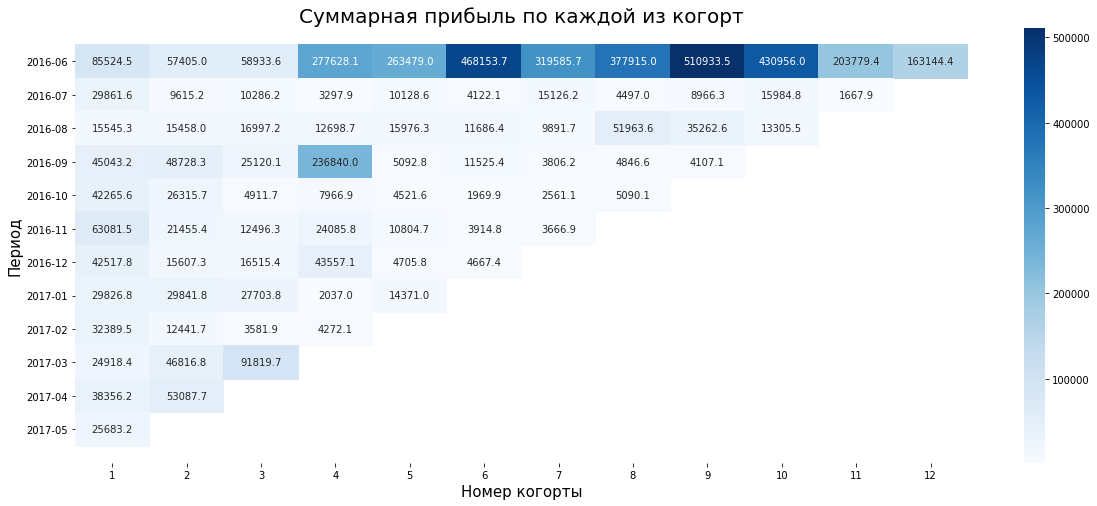

In [19]:
_ = plt.figure(figsize=(20, 8))
ax = sns.heatmap(cohort_summary.T, mask=cohort_summary.T.isnull(), annot=True, cmap='Blues', fmt='.1f')
_ = ax.set_ylabel('Период', fontsize = 15)
_ = ax.set_xlabel('Номер когорты', fontsize = 15)
_ = ax.set_title('Суммарная прибыль по каждой из когорт', fontsize = 20)
bottom_border, top_border = ax.get_ylim()
_ = ax.set_ylim(bottom_border + 0.5, top_border-0.5)

Визуализация суммарной прибыли от каждой когорты пользователей в динамике.

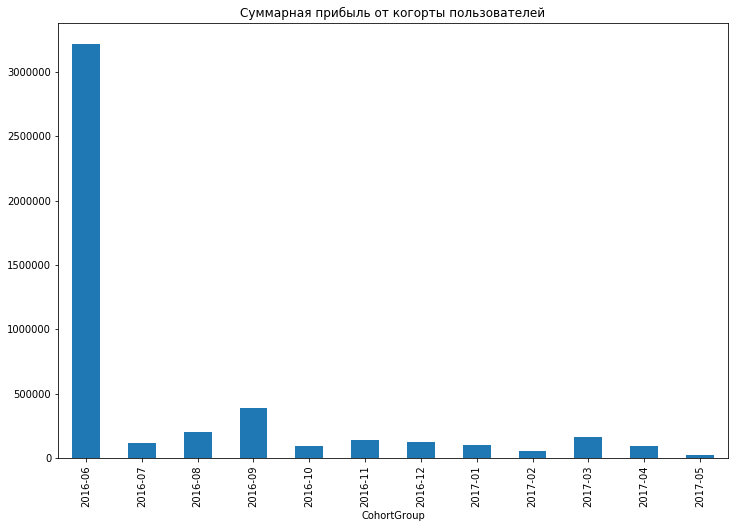

In [20]:
cohort_contrib_margin = cohort_summary.sum(axis=0)
cohort_contrib_margin.plot(kind='bar', figsize=(12,8), title='Суммарная прибыль от когорты пользователей')

#### Подсчет кумулятивной прибыли когорты пользователей в динамике по дням (месяцам)

In [21]:
cohort_cummulative_revenue = cohort_summary.copy()
for col_loc in range(cohort_summary.shape[1]):
    for row_loc in range(cohort_summary.shape[0]):
        cohort_cummulative_revenue.iloc[row_loc, col_loc] = np.sum(cohort_summary.iloc[:row_loc, col_loc])

In [22]:
cohort_cummulative_revenue

CohortGroup,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05
CohortPeriod,,,,,,,,,,,,
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,85524.53,29861.63,15545.35,45043.20,42265.64,63081.46,42517.75,29826.84,32389.50,24918.42,38356.23,25683.21
3,142929.53,39476.82,31003.33,93771.47,68581.34,84536.90,58125.03,59668.59,44831.21,71735.18,91443.89,25683.21
4,201863.17,49763.02,48000.57,118891.61,73493.05,97033.20,74640.48,87372.36,48413.09,163554.90,91443.89,25683.21
5,479491.29,53060.94,60699.30,355731.63,81459.94,121119.02,118197.59,89409.33,52685.17,163554.90,91443.89,25683.21
6,742970.28,63189.55,76675.62,360824.45,85981.52,131923.72,122903.37,103780.29,52685.17,163554.90,91443.89,25683.21
7,1211123.94,67311.68,88362.00,372349.87,87951.38,135838.51,127570.75,103780.29,52685.17,163554.90,91443.89,25683.21
8,1530709.65,82437.86,98253.73,376156.10,90512.53,139505.46,127570.75,103780.29,52685.17,163554.90,91443.89,25683.21
9,1908624.65,86934.88,150217.34,381002.73,95602.65,139505.46,127570.75,103780.29,52685.17,163554.90,91443.89,25683.21


Визуализация кумулятивной прибыли когороты пользователей в динамике по месяцам.

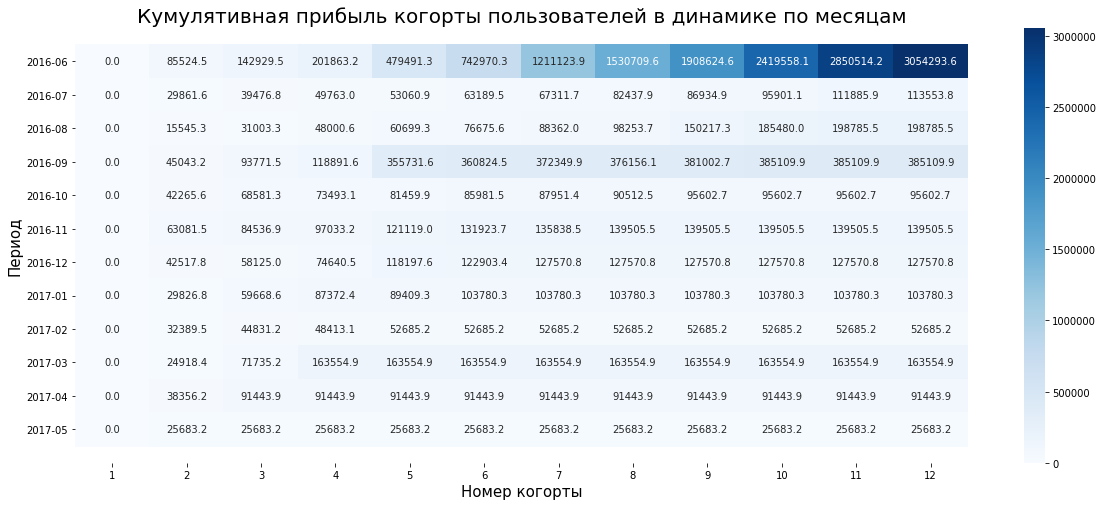

In [23]:
_ = plt.figure(figsize=(20, 8))
ax = sns.heatmap(cohort_cummulative_revenue.T, mask=cohort_cummulative_revenue.T.isnull(), annot=True, cmap='Blues', fmt='.1f')
_ = ax.set_ylabel('Период', fontsize = 15)
_ = ax.set_xlabel('Номер когорты', fontsize = 15)
_ = ax.set_title('Кумулятивная прибыль когорты пользователей в динамике по месяцам', fontsize = 20)
bottom_border, top_border = ax.get_ylim()
_ = ax.set_ylim(bottom_border + 0.5, top_border-0.5)

#### Подсчет динамики LTV когорты пользователей по месяцам

In [24]:
# создадим столбец, определеяющий размер каждой из когорт.
cohort_group_size = cohorts_data['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2016-06    23926
2016-07    22779
2016-08    17688
2016-09    28735
2016-10    43906
Name: TotalUsers, dtype: int64

In [25]:
ltv_cohorts_value = cohort_cummulative_revenue.divide(cohort_group_size, axis=1)
ltv_cohorts_value

CohortGroup,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05
CohortPeriod,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,3.574544,1.310928,0.878864,1.567538,0.962639,1.406499,1.029162,0.798342,0.893775,0.749787,1.509197,1.04086
3,5.973816,1.733036,1.752789,3.263319,1.562004,1.884881,1.406943,1.597082,1.237098,2.158488,3.598028,1.04086
4,8.436979,2.184601,2.713736,4.137519,1.673873,2.163505,1.806707,2.338598,1.335939,4.921313,3.598028,1.04086
5,20.040596,2.329380,3.431666,12.379733,1.855326,2.700536,2.861027,2.393119,1.453825,4.921313,3.598028,1.04086
6,31.052841,2.774027,4.334895,12.556967,1.958309,2.941443,2.974932,2.777771,1.453825,4.921313,3.598028,1.04086
7,50.619575,2.954988,4.995590,12.958061,2.003175,3.028729,3.087908,2.777771,1.453825,4.921313,3.598028,1.04086
8,63.976831,3.619029,5.554824,13.090520,2.061507,3.110490,3.087908,2.777771,1.453825,4.921313,3.598028,1.04086
9,79.771991,3.816448,8.492613,13.259187,2.177439,3.110490,3.087908,2.777771,1.453825,4.921313,3.598028,1.04086


Визуализируем посчитанную динамику LTV по когортам.

Отобразим динамику LTV по когортам с помощью heatmap.

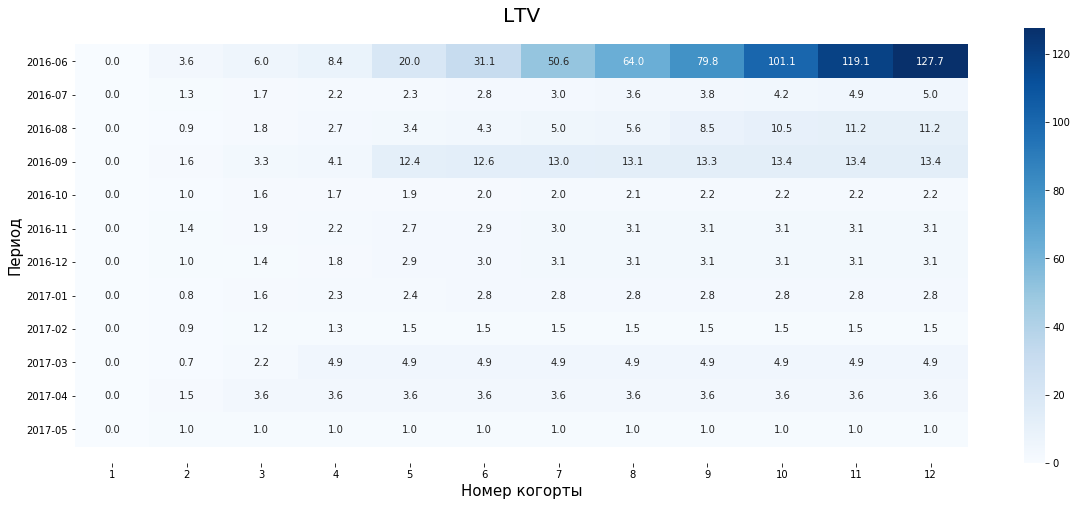

In [26]:
_ = plt.figure(figsize=(20, 8))
ax = sns.heatmap(ltv_cohorts_value.T, mask=ltv_cohorts_value.T.isnull(), annot=True, cmap='Blues', fmt='.1f')
_ = ax.set_ylabel('Период', fontsize = 15)
_ = ax.set_xlabel('Номер когорты', fontsize = 15)
_ = ax.set_title('LTV', fontsize = 20)
bottom_border, top_border = ax.get_ylim()
_ = ax.set_ylim(bottom_border + 0.5, top_border-0.5)

Отобразим динамику LTV по когортам с помощью обычного графика.

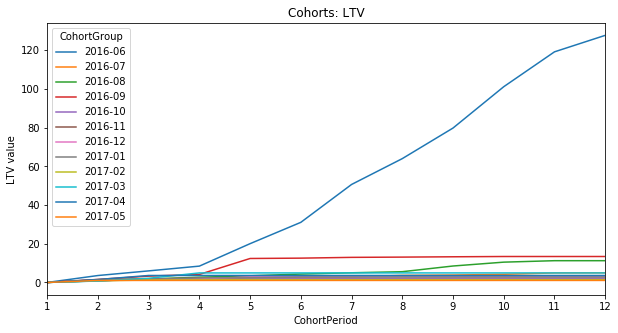

In [28]:
_ = ltv_cohorts_value.plot(figsize=(10,5))
_ = plt.title('Cohorts: LTV')
_ = plt.xticks(np.arange(1, 12.1, 1))
_ = plt.xlim(1, 12)
_ = plt.ylabel('LTV value')

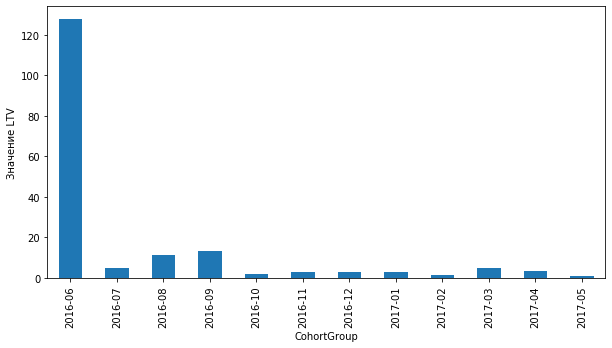

In [29]:
# определим суммарное значение LTV по каждой из когорт
summary_margin_cohort_group = ltv_cohorts_value.loc[ltv_cohorts_value.shape[0],:]
_ = summary_margin_cohort_group.plot(figsize=(10,5), kind='bar')
_ = plt.ylabel('Значение LTV')

#### Подсчет динамики возвращаемости пользователей по месяцам

In [30]:
user_retention = cohorts_data['TotalUsers'].unstack(level=0).divide(cohort_group_size, axis=1)
user_retention

CohortGroup,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05
CohortPeriod,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.0
2,0.107540,0.074147,0.103630,0.112859,0.103198,0.097458,0.075255,0.078049,0.073512,0.057622,0.06087,NaN
3,0.070091,0.067826,0.087743,0.086758,0.066847,0.058573,0.050299,0.051016,0.036011,0.035716,NaN,NaN
4,0.083633,0.076957,0.080507,0.064903,0.052567,0.048183,0.042650,0.031744,0.028174,NaN,NaN,NaN
5,0.095377,0.077484,0.067673,0.054533,0.047192,0.043478,0.027401,0.026605,NaN,NaN,NaN,NaN
6,0.093037,0.064972,0.061228,0.051157,0.044436,0.030479,0.025513,NaN,NaN,NaN,NaN,NaN
7,0.080624,0.063436,0.055122,0.049173,0.030474,0.028852,NaN,NaN,NaN,NaN,NaN,NaN
8,0.074271,0.063962,0.052352,0.032260,0.028197,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.071763,0.052987,0.039236,0.031355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


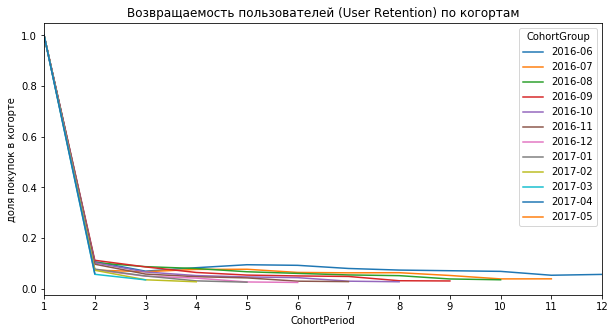

In [32]:
_ = user_retention.plot(figsize=(10,5))
_ = plt.title('Возвращаемость пользователей (User Retention) по когортам')
_ = plt.xticks(np.arange(1, 12.1, 1))
_ = plt.xlim(1, 12)
_ = plt.ylabel('доля покупок в когорте')

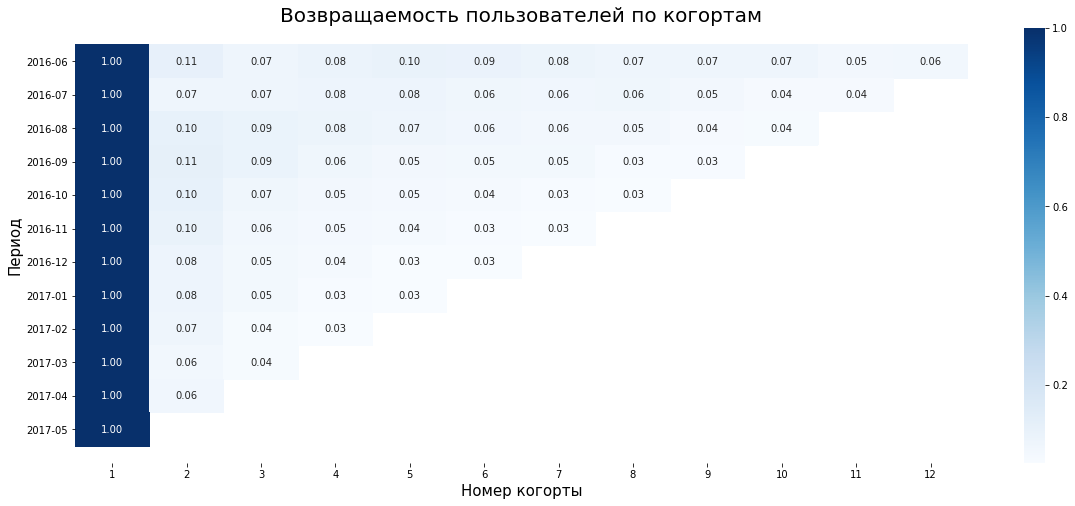

In [33]:
_ = plt.figure(figsize=(20, 8))
ax = sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, cmap='Blues', fmt='.2f')
_ = ax.set_ylabel('Период', fontsize = 15)
_ = ax.set_xlabel('Номер когорты', fontsize = 15)
_ = ax.set_title('Возвращаемость пользователей по когортам', fontsize = 20)
bottom_border, top_border = ax.get_ylim()
_ = ax.set_ylim(bottom_border + 0.5, top_border-0.5)

### Выводы по рассчету LTV

LTV пользователей по каждой когорте равны значениям представленным ниже.

In [88]:
summary_margin_cohort_group

CohortGroup
2016-06    127.655839
2016-07      4.985023
2016-08     11.238439
2016-09     13.402118
2016-10      2.177439
2016-11      3.110490
2016-12      3.087908
2017-01      2.777771
2017-02      1.453825
2017-03      4.921313
2017-04      3.598028
2017-05      1.040860
Name: 12, dtype: float64

Из полученных данных видно, что наибольшее значение LTV в когорте пользователей, которые начали пользоваться сервисом в июне 2016 года, но уже в когорте июльских пользователей мы видим значительное снижение параметра LTV, что свидетельствует об оттоке пользователей из сервиса.

На основании графика суммарной прибыли по когортам можно сделать вывод о том, что ключевой когортой пользователей, приносящей прибыль является июньская когорта. Также немаловажный вклад вносит сентябрьская когорта пользователей. В июньской и сентбрьской когортах отмечается значительный рост прибыли от пользователей на 3 месяце использования сервиса.

Что касается суммарной прибыли, полученной от каждой из когорт, то видно, что значительная часть прибыли получена от пользователей когорты июня 2016 года (68% от полученной прибыли за рассматриваемый период на сумму 3217438 у.е).

In [34]:
cohort_contrib_margin.divide(cohort_contrib_margin.sum())
cohort_contrib_margin

CohortGroup
2016-06    0.682425
2016-07    0.024085
2016-08    0.042163
2016-09    0.081683
2016-10    0.020278
2016-11    0.029589
2016-12    0.027058
2017-01    0.022012
2017-02    0.011175
2017-03    0.034690
2017-04    0.019395
2017-05    0.005447
dtype: float64

CohortGroup
2016-06    3217438.04
2016-07     113553.83
2016-08     198785.51
2016-09     385109.87
2016-10      95602.65
2016-11     139505.46
2016-12     127570.75
2017-01     103780.29
2017-02      52685.17
2017-03     163554.90
2017-04      91443.89
2017-05      25683.21
dtype: float64

Размеры каждой из когорт пропорциональны друг другу, но анализ retention rate (частота возвращаемости пользователей), показывает, что в конечном итоге использовать сервис продолжает от 3 до 6% пользователей когорты (наибольшее значение в июньской когорте-6%). 

In [35]:
cohort_group_size = cohorts_data['TotalUsers'].groupby(level=0).first()
cohort_group_size
cohort_group_size.divide(cohort_group_size.sum())

CohortGroup
2016-06    23926
2016-07    22779
2016-08    17688
2016-09    28735
2016-10    43906
2016-11    44850
2016-12    41313
2017-01    37361
2017-02    36239
2017-03    33234
2017-04    25415
2017-05    24675
Name: TotalUsers, dtype: int64

CohortGroup
2016-06    0.062943
2016-07    0.059926
2016-08    0.046533
2016-09    0.075594
2016-10    0.115505
2016-11    0.117989
2016-12    0.108684
2017-01    0.098287
2017-02    0.095335
2017-03    0.087430
2017-04    0.066860
2017-05    0.064914
Name: TotalUsers, dtype: float64

На графике динамики LTV каждой из когорт по месяцам также виден значительный рост метрики LTV для когорты пользователей июня 2016 года. Для всех остальных когорт, за исключением когорт августа и сентября 2016 года не отмечается рост метрики LTV.

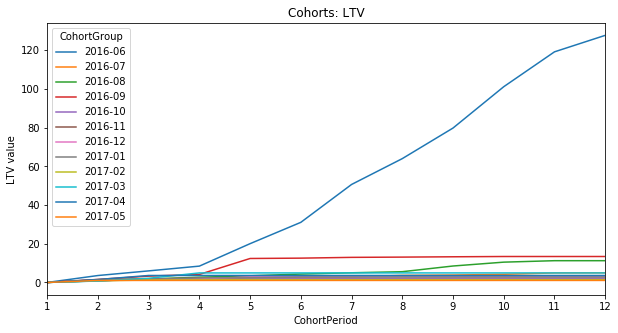

In [36]:
_ = ltv_cohorts_value.plot(figsize=(10,5))
_ = plt.title('Cohorts: LTV')
_ = plt.xticks(np.arange(1, 12.1, 1))
_ = plt.xlim(1, 12)
_ = plt.ylabel('LTV value')